In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay , f1_score , roc_auc_score , precision_score , recall_score , accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
import pickle
import os, sys


**One hot encode Categorical values**

In [26]:
loan_df = pd.read_csv('eda_out.csv')

In [27]:
purpose_cat = list(loan_df['purpose'].unique())
purpose_cat

['debt_consolidation',
 'credit_card',
 'all_other',
 'home_improvement',
 'small_business',
 'major_purchase',
 'educational']

In [28]:
onehot_encoder = OneHotEncoder( sparse=False)
onehot_encoded = onehot_encoder.fit_transform(loan_df['purpose'].values.reshape(-1,1))
onehot_encoded_df = pd.DataFrame(onehot_encoded , columns= onehot_encoder.get_feature_names_out())
onehot_encoded_df.head()


/Users/dbvaddi/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,x0_all_other,x0_credit_card,x0_debt_consolidation,x0_educational,x0_home_improvement,x0_major_purchase,x0_small_business
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [29]:
loan_df_ohe = loan_df.join(onehot_encoded_df)

In [30]:
loan_df = loan_df_ohe.drop('purpose', axis=1)
loan_df.drop(loan_df.columns[loan_df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
loan_df.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,x0_all_other,x0_credit_card,x0_debt_consolidation,x0_educational,x0_home_improvement,x0_major_purchase,x0_small_business
0,True,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,True,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,True,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,True,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,True,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [31]:
loan_df.dtypes

credit.policy               bool
int.rate                 float64
installment              float64
log.annual.inc           float64
dti                      float64
fico                       int64
days.with.cr.line        float64
revol.bal                  int64
revol.util               float64
inq.last.6mths             int64
delinq.2yrs                int64
pub.rec                    int64
not.fully.paid              bool
x0_all_other             float64
x0_credit_card           float64
x0_debt_consolidation    float64
x0_educational           float64
x0_home_improvement      float64
x0_major_purchase        float64
x0_small_business        float64
dtype: object

**Define X and y , Split Train/test and Scale**

In [32]:
X = loan_df.drop(columns = 'not.fully.paid')
y = loan_df['not.fully.paid']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 11, stratify = y)

In [34]:
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [35]:
## function to dispaly confusion matrix
def disp_cm( y_test  , ytest_pred ):
    cm = confusion_matrix(y_test, ytest_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()    

In [36]:
results_df = pd.DataFrame(columns=['model_name','f1' , 'roc_auc' 
                                   , 'precision' , 'recall' , 'accuracy'
])

In [37]:
def score_calc(model_name , y_test,ytest_pred):
    roc_auc = roc_auc_score(y_test,ytest_pred)
    f1 = f1_score(y_test, ytest_pred)
    precision = precision_score(y_test, ytest_pred)
    recall = recall_score(y_test,ytest_pred)
    accuracy = accuracy_score(y_test , ytest_pred)
    append_res(model_name,f1, roc_auc, precision,recall , accuracy)

In [38]:
## insert into dataframe 
def append_res(model_name , f1 , roc_auc , precision , recall , accuracy):
    results_df.loc[len(results_df.index)] = [model_name , f1 , roc_auc , precision , recall , accuracy]

## Basic Logreg for baseline

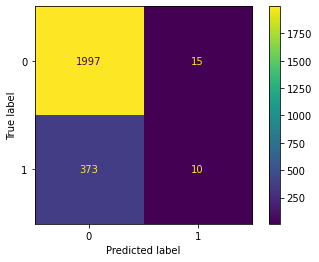

In [39]:
lr = LogisticRegression()
lr.fit(Xs_train,y_train)
lr.score(Xs_train,y_train) , lr.score(Xs_test,y_test)
y_pred_lr = lr.predict(Xs_test)
score_calc('logreg',y_test , y_pred_lr)
disp_cm(y_test , y_pred_lr)

## XGBoost

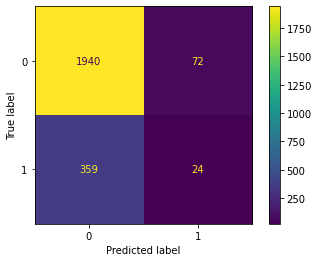

In [40]:
xgbc_base = XGBClassifier(random_state=0)
xgbc_base.fit(Xs_train, y_train)
y_pred_xg = xgbc_base.predict(Xs_test)
score_calc('XGBoost', y_test , y_pred_xg)
disp_cm(y_test , y_pred_xg)


## XGboost Scale Pos adjusted

In [41]:
loan_df['not.fully.paid'].value_counts()

not.fully.paid
False    8045
True     1533
Name: count, dtype: int64

In [42]:
8045/1533

5.247879973907371

In [43]:
y_test.value_counts()

not.fully.paid
False    2012
True      383
Name: count, dtype: int64

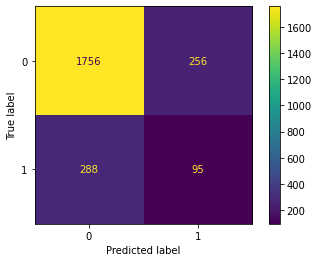

In [44]:
xgbc_pos5 = XGBClassifier(random_state=0, scale_pos_weight= 5)
xgbc_pos5.fit(Xs_train, y_train)
y_pred_xg5 = xgbc_pos5.predict(Xs_test)
score_calc('XGBoost_pos5', y_test , y_pred_xg5)
disp_cm(y_test , y_pred_xg5)

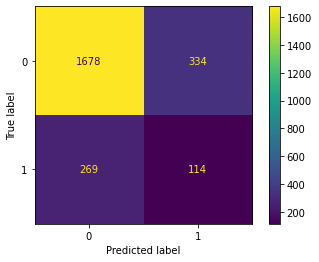

In [45]:
xgbc_pos7 = XGBClassifier(random_state=0, scale_pos_weight= 7)
xgbc_pos7.fit(Xs_train, y_train)
y_pred_xg7 = xgbc_pos7.predict(Xs_test)
score_calc('XGBoost_pos7', y_test , y_pred_xg7)
disp_cm(y_test , y_pred_xg7)

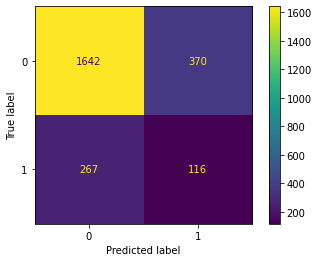

In [46]:
xgbc_pos9 = XGBClassifier(random_state=0, scale_pos_weight= 9)
xgbc_pos9.fit(Xs_train, y_train)
y_pred_xg9 = xgbc_pos9.predict(Xs_test)
score_calc('XGBoost_pos9', y_test , y_pred_xg9)
disp_cm(y_test , y_pred_xg9)

In [47]:
results_df

,model_name,f1,roc_auc,precision,recall,accuracy
0,logreg,0.049020,0.509327,0.400000,0.026110,0.837996
1,XGBoost,0.100209,0.513439,0.250000,0.062663,0.820042
2,XGBoost_pos5,0.258856,0.560403,0.270655,0.248042,0.772860
3,XGBoost_pos7,0.274368,0.565823,0.254464,0.297650,0.748225
4,XGBoost_pos9,0.266974,0.559488,0.238683,0.302872,0.734029


As we increase scale_pos_weight , recall is better but at the expense of precision. Decision would be based on the cost of lost opportunity for false positves vs savings with true positves

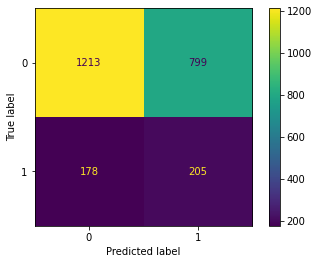

In [48]:
xgbc_pos49 = XGBClassifier(random_state=0, scale_pos_weight= 49)
xgbc_pos49.fit(Xs_train, y_train)
y_pred_xg49 = xgbc_pos49.predict(Xs_test)
score_calc('XGBoost_pos49', y_test , y_pred_xg49)
disp_cm(y_test , y_pred_xg49)

In [49]:
xgb_params = {'scale_pos_weight': range(0, 150 , 2)}


In [50]:
xgb_gridsearch = GridSearchCV(xgbc_base,
                              xgb_params, 
                              cv=5, 
                              verbose=1, 
                              scoring = 'recall')

In [51]:
xgb_gridsearch.fit(Xs_train,y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'scale_pos_weight': range(0, 150, 2)},
             scoring='recall', verbose=1)

In [52]:
xgb_gridsearch.best_params_

{'scale_pos_weight': 106}

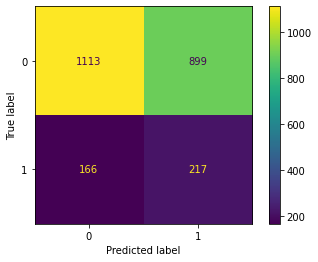

In [53]:
y_pred_xgbgs = xgb_gridsearch.predict(Xs_test)
score_calc('XGB_gridsearch', y_test , y_pred_xgbgs)
disp_cm(y_test , y_pred_xgbgs)

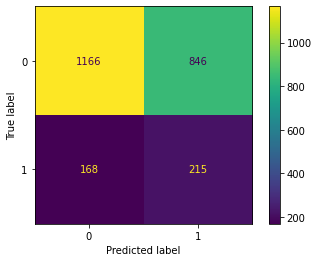

In [54]:
xgbc_pos99 = XGBClassifier(random_state=0, scale_pos_weight= 99)
xgbc_pos99.fit(Xs_train, y_train)
y_pred_xg99 = xgbc_pos99.predict(Xs_test)
score_calc('XGBoost_pos99', y_test , y_pred_xg99)
disp_cm(y_test , y_pred_xg99)

## LightGBM

### Default

[LightGBM] [Info] Number of positive: 1150, number of negative: 6033
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1858
[LightGBM] [Info] Number of data points in the train set: 7183, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160100 -> initscore=-1.657482
[LightGBM] [Info] Start training from score -1.657482


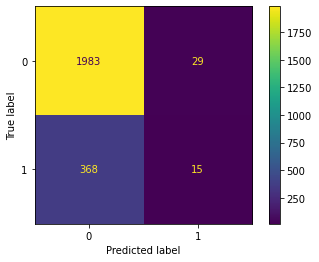

In [55]:
lgbm_def = LGBMClassifier(random_state=0)
lgbm_def.fit(Xs_train, y_train)
y_pred_lgbm = lgbm_def.predict(Xs_test)
score_calc('LightGBM_default', y_test , y_pred_lgbm)
disp_cm(y_test , y_pred_lgbm)

In [56]:
results_df

,model_name,f1,roc_auc,precision,recall,accuracy
0,logreg,0.049020,0.509327,0.400000,0.026110,0.837996
1,XGBoost,0.100209,0.513439,0.250000,0.062663,0.820042
2,XGBoost_pos5,0.258856,0.560403,0.270655,0.248042,0.772860
3,XGBoost_pos7,0.274368,0.565823,0.254464,0.297650,0.748225
4,XGBoost_pos9,0.266974,0.559488,0.238683,0.302872,0.734029
5,XGBoost_pos49,0.295602,0.569065,0.204183,0.535248,0.592067
6,XGB_gridsearch,0.289526,0.559880,0.194444,0.566580,0.555324
7,XGBoost_pos99,0.297784,0.570440,0.202639,0.561358,0.576618
8,LightGBM_default,0.070258,0.512375,0.340909,0.039164,0.834238


## KNN

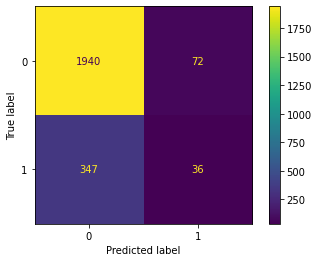

In [57]:
knn_def = KNeighborsClassifier()
knn_def.fit(Xs_train, y_train)
y_pred_knn = knn_def.predict(Xs_test)
score_calc('KNN_default', y_test , y_pred_knn)
disp_cm(y_test , y_pred_knn)

In [58]:
knn_params = {
    'n_neighbors': [1,3, 5, 7, 9 ],
    'p': [1,2,3,4],
    'weights': ['uniform', 'distance']
}

In [59]:
knn_gridsearch = GridSearchCV(knn_def,
                              knn_params, 
                              cv=5, 
                              verbose=1, 
                              scoring = 'recall')

In [60]:
knn_gridsearch.fit(Xs_train,y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9], 'p': [1, 2, 3, 4],
                         'weights': ['uniform', 'distance']},
             scoring='recall', verbose=1)

In [61]:
knn_gridsearch.best_params_

{'n_neighbors': 1, 'p': 3, 'weights': 'uniform'}

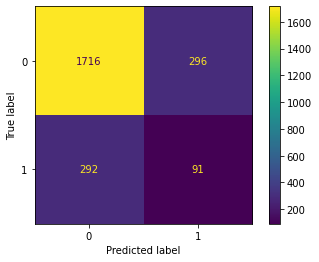

In [62]:
y_pred_knngs = knn_gridsearch.predict(Xs_test)
score_calc('KNN_gridsearch', y_test , y_pred_knngs)
disp_cm(y_test , y_pred_knngs)

In [63]:
results_df

,model_name,f1,roc_auc,precision,recall,accuracy
0,logreg,0.049020,0.509327,0.400000,0.026110,0.837996
1,XGBoost,0.100209,0.513439,0.250000,0.062663,0.820042
2,XGBoost_pos5,0.258856,0.560403,0.270655,0.248042,0.772860
3,XGBoost_pos7,0.274368,0.565823,0.254464,0.297650,0.748225
4,XGBoost_pos9,0.266974,0.559488,0.238683,0.302872,0.734029
5,XGBoost_pos49,0.295602,0.569065,0.204183,0.535248,0.592067
6,XGB_gridsearch,0.289526,0.559880,0.194444,0.566580,0.555324
7,XGBoost_pos99,0.297784,0.570440,0.202639,0.561358,0.576618
8,LightGBM_default,0.070258,0.512375,0.340909,0.039164,0.834238
9,KNN_default,0.146640,0.529105,0.333333,0.093995,0.825052


In [64]:
os.getcwd()

'/Users/dbvaddi/Desktop/MachineLearning_Coursera/Loans_LC'

In [65]:
pickle.dump(xgb_gridsearch, open('xgb_gs_model.p', 'wb'))

In [67]:
## saving the best estiamtor using xgb save_model since pickle had issues reading the xgb model
best_xgbgs = xgb_gridsearch.best_estimator_
best_xgbgs.save_model('best_xgbgs.json')

In [68]:
data = [True 0.1234 100.25 11.512925464970229 14.29 305 50.0 234 234.0 123 134 1 1.0 1.0 0.0 0.0 0.0 0.0 0.0]

SyntaxError: invalid syntax (<ipython-input-68-58dd945926dd>, line 1)

In [69]:
X_test.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,x0_all_other,x0_credit_card,x0_debt_consolidation,x0_educational,x0_home_improvement,x0_major_purchase,x0_small_business
9126,False,0.1158,99.05,10.915088,7.55,712,11310.000000,2245,11.5,5,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6647,True,0.1218,333.00,9.798127,10.07,707,4560.041667,7159,73.1,1,1,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4126,True,0.1287,605.40,10.674429,13.27,707,5430.000000,3423,15.2,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2665,True,0.1379,286.24,10.714418,24.75,697,4829.958333,1924,91.6,1,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2181,True,0.1600,527.36,11.034890,7.39,672,7800.041667,11307,50.0,3,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [71]:
with open('std_scaler.pkl', 'wb') as scaler_file:
    pickle.dump(ss, scaler_file)

array([[-2.02612644, -0.2566205 , -1.06527802, ..., -0.26640313,
        -0.22359045, -0.2600535 ],
       [ 0.49355261, -0.03307533,  0.05829379, ...,  3.75370965,
        -0.22359045, -0.2600535 ],
       [ 0.49355261,  0.22400162,  1.36652614, ..., -0.26640313,
        -0.22359045, -0.2600535 ],
       ...,
       [ 0.49355261, -1.09864064, -0.11407207, ..., -0.26640313,
        -0.22359045, -0.2600535 ],
       [ 0.49355261,  0.09732602,  0.06631415, ..., -0.26640313,
        -0.22359045, -0.2600535 ],
       [ 0.49355261, -0.2566205 , -0.74820937, ..., -0.26640313,
        -0.22359045, -0.2600535 ]])